In [1]:
import sys
# sys.path.append("/home/federico/programming/CM/")
sys.path.append("/home/federico/Desktop/University/CM/")

In [2]:
from src.LS.LS import LS
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import random
import sys
import time
import matplotlib.pyplot as plt

from src.NN.utils import *
from src.NN.metrics import mean_squared_error

from datetime import datetime as dt
import time

In [3]:
def generate(m, n):
    """Generates a random dataset starting from the given dimensions.

    :param m: Number of rows for the coefficient matrix (i.e. length of the vector b).
    :param n: Number of columns for the coefficient matrix (i.e. length of the vector x in (P)).
    :return: The coefficient matrix M and the dependent variables vector b.
    """

    M = np.array([ [random.gauss(0,1) for r in range(n)] for c in range(m) ], dtype=float)
    b = np.array([random.gauss(0,1) for r in range(m)], dtype=float)
    return M, b.reshape(-1,1)


def scaling (starting_m, m, n, step, t, save=True) :
    """Tests the QR factorization for different matrices with m in [200, 5000] and n=50.
    Executes each example for a given amount of time and averages the times accordingly. For each result
    prints the size m and the average execution time, together with the time difference from the previous
    result.

    At the end of the process, saves an image showing the evolution of execution times over the increase
    of dimension m. The resulting image is saved in the resource folder as 'QRscaling_n50.png'.
    """

    print(f"n={n}, m={m}, t={t}")
    print(f"m{'':7} QR A3{'':<5s} delta{'':<5s} QR np{'':<5s} delta{'':<5s} LS A3{'':<5s} delta{'':<5s} LS np{'':<5s} delta{'':<5s}")
    print("----------------------------------------------------------------------------------------------------")
    
    stats = ""
    
    time_qr_a3 = []
    time_qr_np = []
    time_ls_a3 = []
    time_ls_np = []
    
    prev_qr_a3 = 0
    prev_qr_np = 0
    prev_ls_a3 = 0
    prev_ls_np = 0
    
    ls = LS()
    mrange = range(starting_m,m,step)
    for m in mrange:
        
        A,b = generate(m,n)
        mean_qr_a3 = 0
        mean_qr_np = 0
        mean_ls_a3 = 0
        mean_ls_np = 0
        
        for i in range(t):
            startQR = dt.now()
            R = ls.qr(A)
            Q = ls.revertQ()
            QR = np.matmul(Q, R)
            endQR = end_time(startQR)
            endQR = endQR.seconds*1000 + endQR.microseconds/1000
            mean_qr_a3 += endQR

            startQRnp = dt.now()
            Qnp, Rnp = np.linalg.qr(A)
            QRnp = np.matmul(Qnp, Rnp)
            endQRnp = end_time(startQRnp)
            endQRnp = endQRnp.seconds*1000 + endQRnp.microseconds/1000
            mean_qr_np += endQRnp
            
            # Computes time for LS solver 
            startLS = dt.now()
            res = ls.solve(A,b)
            endLS = end_time(startLS)
            endLS = endLS.seconds*1000 + endLS.microseconds/1000
            mean_ls_a3 += endLS
            
            # Computes time for LS solver using numpy
            startLSnp = dt.now()
            resnp, _, _, _ = np.linalg.lstsq(A,b,rcond=-1)
            endLSnp = end_time(startLSnp)
            endLSnp = endLSnp.seconds*1000 + endLSnp.microseconds/1000
            mean_ls_np += endLSnp
        
        mean_qr_a3 = (mean_qr_a3 / t)
        mean_qr_np = (mean_qr_np / t)
        mean_ls_a3 = (mean_ls_a3 / t)
        mean_ls_np = (mean_ls_np / t)
        
        delta_qr_a3 = mean_qr_a3 - prev_qr_a3
        delta_qr_np = mean_qr_np - prev_qr_np
        delta_ls_a3 = mean_ls_a3 - prev_ls_a3
        delta_ls_np = mean_ls_np - prev_ls_np
        
        time_qr_a3.append(mean_qr_a3)
        time_qr_np.append(mean_qr_np)
        time_ls_a3.append(mean_ls_a3)
        time_ls_np.append(mean_ls_np)
        
        prev_qr_a3 = mean_qr_a3
        prev_qr_np = mean_qr_np
        prev_ls_a3 = mean_ls_a3
        prev_ls_np = mean_ls_np
        
        stats += (f"Solved (m x n): ({m},{n}) in {mean_ls_a3} msec, w/ np in {mean_ls_np} msec"\
        f"- Reverting and reconstruction: {mean_qr_a3} msec, w/ np took: {mean_qr_np} msec\n"\
        f"res error: {np.linalg.norm( b - np.dot(A, res) )/np.linalg.norm(b)} "\
        f"- np_res error: {np.linalg.norm( b - np.dot(A, resnp) )/np.linalg.norm(b)}\n"\
        f"QR error: {np.linalg.norm( A - QR )/np.linalg.norm(A)} "\
        f"- QR error w/ np: {np.linalg.norm( A - QRnp )/np.linalg.norm(A)}\n\n")
        
        print(f"{m:<6} || {mean_qr_a3:8.4f} | {delta_qr_a3:8.4f} | {mean_qr_np:8.4f} | {delta_qr_np:8.4f} "\
             f"| {mean_ls_a3:8.4f} | {delta_ls_a3:8.4f} | {mean_ls_np:8.4f} | {delta_ls_np:8.4f}")
        

    print(stats)
    
    # --- Plotting QR stats ---
    plt.plot(mrange, time_qr_np, "^-", label="np")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"QR factorizzation of a matrix {m}x{n} (NP)")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/QRscaling_np_n{n}m{m}.png")
    else: plt.show()
    plt.clf()

    plt.plot (mrange, time_qr_a3, "o-", label="mio")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"QR factorizzation of a matrix {m}x{n} (A3)")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/QRscaling_a3_n{n}m{m}.png")
    else: plt.show()
    plt.clf()
    
    plt.plot(mrange, time_qr_np, "^-", label="np")
    plt.plot (mrange, time_qr_a3, "o-", label="(A3)")
    plt.legend()
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"QR factorizzation of a matrix {m}x{n}")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/QRscaling_comparison_n{n}m{m}.png")
    else: plt.show()
    plt.clf()
    
    
    # --- Plotting LS stats ---
    plt.plot(mrange, time_ls_np, "^-")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"LS of a matrix {m}x{n} (NP)")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/LSscaling_np_n{n}m{m}.png")
    else: plt.show()
    plt.clf()

    plt.plot (mrange, time_ls_a3, "o-")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"LS of a matrix {m}x{n} (A3)")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/LSscaling_a3_n{n}m{m}.png")
    else: plt.show()
    plt.clf()
    
    plt.plot(mrange, time_qr_np, "^-", label="np")
    plt.plot (mrange, time_qr_a3, "o-", label="(A3)")
    plt.legend()
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"LS of a matrix {m}x{n}")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/LSscaling_comparison_n{n}m{m}.png")
    else: plt.show()
    plt.clf()
    

def automatized_test(M, b, test_type):
    ls = LS()
    m = M.shape[0]
    n = M.shape[1]

    # Computes time for LS solver 
    startLS = dt.now()
    res = ls.solve(M,b)
    endLS = end_time(startLS)
    endLS = endLS.seconds*1000 + endLS.microseconds/1000

    # Computes time for Q and QR reconstruction
    startQR = dt.now()
    R = ls.qr(M)
    Q = ls.revertQ()
    QR = np.matmul(Q, R)
    endQR = end_time(startQR)
    endQR = endQR.seconds*1000 + endQR.microseconds/1000

    # Computes QR factorization using numpy
    startQRnp = dt.now()
    Qnp, Rnp = np.linalg.qr(M)
    QRnp = np.matmul(Qnp, Rnp)
    endQRnp = end_time(startQRnp)
    endQRnp = endQRnp.seconds*1000 + endQRnp.microseconds/1000

    # Computes time for LS solver using numpy
    startLSnp = dt.now()
    resnp, _, _, _ = np.linalg.lstsq(M,b,rcond=-1)
    endLSnp = end_time(startLSnp)
    endLSnp = endLSnp.seconds*1000 + endLSnp.microseconds/1000

    print(f"---------- {test_type} DATASET ----------")
    print(f"Solved (m x n): ({m},{n}) in {endLS} msec, w/ np in {endLSnp} msec \
    - Reverting and reconstruction: {endQR} msec, w/ np took: {endQRnp} msec")
    print(f"res error: {np.linalg.norm( b - M@res )/np.linalg.norm(b)} "\
    f"- np_res error: {np.linalg.norm( b - np.matmul(M, resnp) )/np.linalg.norm(b)}")
    print(f"QR error: {np.linalg.norm( M - QR )/np.linalg.norm(M)} "\
    f"- QR error w/ np: {np.linalg.norm( M - QRnp )/np.linalg.norm(M)}\n")
    
    print(f"{np.linalg.norm( b - np.matmul(M, resnp) )}")
    print(f"{np.sum((b - np.matmul(M,resnp))**2)}")
    
    return res, resnp

# Scaling test

n=100, m=11000, t=20
m        QR A3      delta      QR np      delta      LS A3      delta      LS np      delta     
----------------------------------------------------------------------------------------------------
1000   || 217.6238 | 217.6238 |   5.6033 |   5.6033 |  53.5470 |  53.5470 |   7.2324 |   7.2324
2000   || 256.1771 |  38.5533 |   7.3353 |   1.7319 |  61.8159 |   8.2689 |   8.5753 |   1.3430
3000   || 319.1275 |  62.9504 |   8.8052 |   1.4699 |  91.4905 |  29.6746 |   9.6398 |   1.0645
4000   || 380.9561 |  61.8286 |  10.4691 |   1.6639 | 135.7963 |  44.3058 |  11.3454 |   1.7056
5000   || 446.6894 |  65.7333 |  13.5161 |   3.0470 | 163.8329 |  28.0366 |  13.6105 |   2.2651
6000   || 514.2344 |  67.5450 |  15.5105 |   1.9944 | 197.2638 |  33.4309 |  16.3733 |   2.7628
7000   || 571.1345 |  56.9001 |  19.4027 |   3.8922 | 229.0968 |  31.8330 |  17.6966 |   1.3233
8000   || 631.9952 |  60.8607 |  22.3730 |   2.9703 | 265.3841 |  36.2874 |  19.6250 |   1.9284
9000   || 688

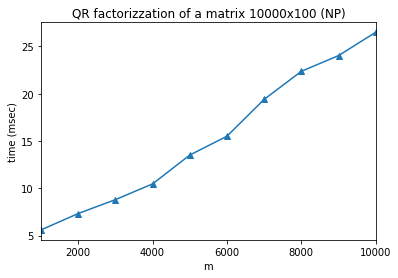

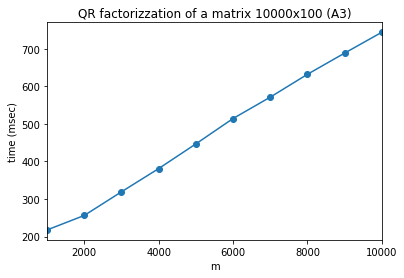

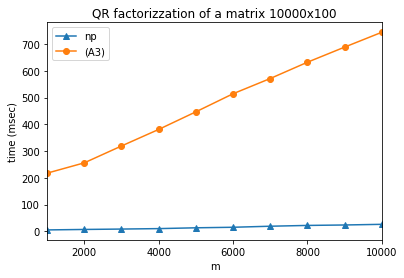

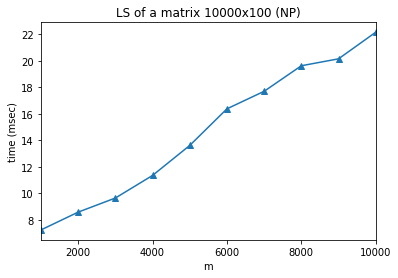

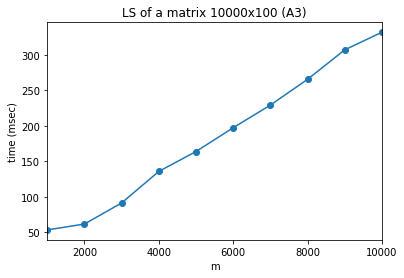

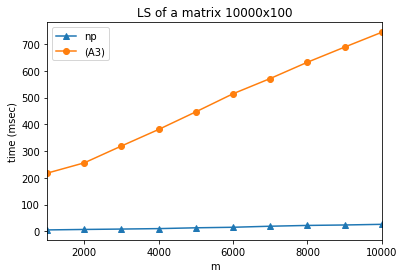

<Figure size 432x288 with 0 Axes>

In [5]:
starting_m = 1000
last_m = 11000
n = 100
step = 1000
repeat = 20
scaling(starting_m, last_m, n, step, repeat, save=False)

# CUP test

In [4]:
cup = '../../data/ML-CUP20-TR.csv'

In [5]:
M, M_test, b, b_test = load_CUP(cup, split=0)
res, resnp = automatized_test(M, b, 'CUP')
print(f"MSE A3: {mean_squared_error(np.matmul(M, res),b)}")
print(f"MSE np: {mean_squared_error(np.matmul(M, resnp),b)}\n\n")


A,b = generate(5000,50)
res, resnp = automatized_test(A, b, 'RANDOM')
print(f"MSE A3: {mean_squared_error(np.matmul(A, res),b)}")
print(f"MSE np: {mean_squared_error(np.matmul(A, resnp),b)}")

---------- CUP DATASET ----------
Solved (m x n): (1524,10) in 15.172 msec, w/ np in 1.253 msec     - Reverting and reconstruction: 6.464 msec, w/ np took: 5.461 msec
res error: 1.0537730959643323 - np_res error: 0.9962999753126452
QR error: 4.985905640396062e-16 - QR error w/ np: 3.2893174070752376e-16

2301.982841336337
5299125.001806917
MSE A3: 972.4632084924591
MSE np: 869.279035729481


---------- RANDOM DATASET ----------
Solved (m x n): (5000,50) in 61.304 msec, w/ np in 8.675 msec     - Reverting and reconstruction: 172.863 msec, w/ np took: 11.601 msec
res error: 1.0064993413587273 - np_res error: 0.995069332457196
QR error: 8.549483464177714e-16 - QR error w/ np: 3.912319423692782e-16

69.05872400850221
4769.107361682477
MSE A3: 0.48792987056099674
MSE np: 0.4769107361682477
